In [1]:
import os
import tarfile
import urllib
import numpy as np
import pickle
import pandas as pd
import datetime
import numpy as np

In [2]:
X_PATH = '../datasets/mnist_X_train.pkl';
Y_PATH = '../datasets/mnist_y_train.pkl';

In [3]:
def load_data(path):
    return pd.read_pickle(path)

In [4]:
#Load Initial Data
x_training = load_data(X_PATH)
y_labels = load_data(Y_PATH)

6


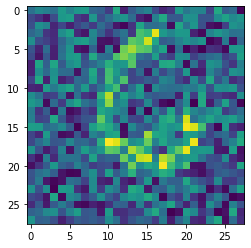

In [5]:
## View how Data is arranged
from matplotlib import pyplot as plt
im = np.asarray(x_training[3])
im = np.reshape(im, (28,28)) ### Reshape it to square dimensions because it's an image

#### We may want to consider converting these to grayscale values ##########
plt.figure;
plt.imshow(im);
print(y_labels[3])

In [6]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [1]:
#### Split Data #####
#X_train, X_test, y_train, y_test=train_test_split(x_training, y_labels, test_size=.3, shuffle = True,random_state = 42)
X_train, X_test, y_train, y_test=train_test_split(x_training, y_labels, test_size=.3, stratify = y_labels,random_state = 0)

NameError: name 'x_training' is not defined

### Ideas on how to Preprocess Data
Start by converting our data from 16 bit rgb to 8 bit grayscale first  
Now that we know our data is grayscale whose max pixel value is 255, we can then normalize our data

Try denoise

4


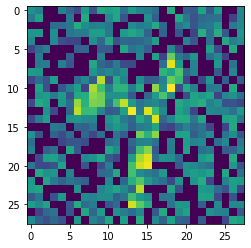

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import cv2 as cv2
from scipy import signal

### This shows that we can convert our rows into 28x28 images that are 8 bit and normalized.

img_n = cv2.normalize(src=x_training[100], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
ret, thresh1 = cv2.threshold(img_n,50,255,cv2.THRESH_TOZERO)
thresh1 = thresh1 /255
plt.imshow(thresh1.reshape(28,28));
print(y_labels[100])

In [9]:
#Custom Pipeline Transform to convert to each row to 8 bit grayscale
class convert_grayscale_transform(BaseEstimator, TransformerMixin):
    def __init__(self, convert_grayscale=True): # no *args or **kargs
        self.convert_grayscale = convert_grayscale;
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        if self.convert_grayscale:
            X_ = X.copy()
            for idx,im in enumerate(X_):
                im = cv2.normalize(im, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)/255;
                X_[idx,:] = im[:,0]
            return X_;
            #return cv2.normalize(X, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)/255.0;
        else:
            return self

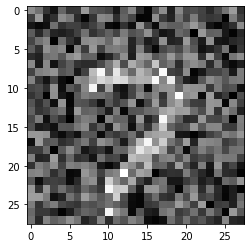

In [10]:
from sklearn.preprocessing import StandardScaler
# EZ pipeline
num_pipeline = Pipeline([
    ('convert_to_Gray', convert_grayscale_transform())
])

#Fit data as a test;
transformed_x_train = num_pipeline.fit_transform(X_train);
transformed_x_test = num_pipeline.transform(X_test);
#transformed_x_train[9]
## Shows that grayscale works within the pipeline
plt.imshow(transformed_x_train[3].reshape(28,28), cmap='gray');


In [11]:
# Display Cross Validation Scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("STD:", scores.std())

# Stochastic Gradient Descent (SGD Classifier)

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(transformed_x_train, y_train)

SGDClassifier(random_state=42)

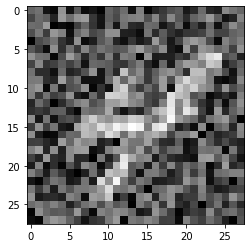

In [13]:
some_digit = transformed_x_test[3];
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = 'gray');

In [14]:
print(sgd_clf.predict([some_digit]))
print(y_test[3])

[4]
4


In [15]:
# Don't use accuracy or classiiers. Use Confusion Matrix instead and measure Precision
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

SGD_y_predict_score = cross_val_score(sgd_clf, transformed_x_train, y_train, cv=3, scoring="accuracy")
SGD_y_predict_train = cross_val_predict(sgd_clf, transformed_x_train, y_train, cv=3)
SGD_confusion_train = confusion_matrix(y_train, SGD_y_predict_train);
print(SGD_y_predict_score)

[0.80335714 0.79857143 0.79507143]


# KNN Classifier
will attempt to do grid search using : https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [12,13,14]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(transformed_x_train, y_train)

#knn_clf.fit(transformed_x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................n_neighbors=12, weights=uniform; total time=  17.1s
[CV 2/5] END ................n_neighbors=12, weights=uniform; total time=  14.7s
[CV 3/5] END ................n_neighbors=12, weights=uniform; total time=  14.9s
[CV 4/5] END ................n_neighbors=12, weights=uniform; total time=  14.8s
[CV 5/5] END ................n_neighbors=12, weights=uniform; total time=  14.1s
[CV 1/5] END ...............n_neighbors=12, weights=distance; total time=  14.4s
[CV 2/5] END ...............n_neighbors=12, weights=distance; total time=  13.0s
[CV 3/5] END ...............n_neighbors=12, weights=distance; total time=  15.2s
[CV 4/5] END ...............n_neighbors=12, weights=distance; total time=  14.7s
[CV 5/5] END ...............n_neighbors=12, weights=distance; total time=  15.4s
[CV 1/5] END ................n_neighbors=13, weights=uniform; total time=  16.5s
[CV 2/5] END ................n_neighbors=13, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [12, 13, 14],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [31]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_neighbors': 14, 'weights': 'distance'}
0.8952142857142859


In [32]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(transformed_x_test)
accuracy_score(y_test, y_pred)

0.8946111111111111

In [33]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(transformed_x_train, y_train)

KNeighborsClassifier(n_neighbors=14, weights='distance')

In [20]:
KNN_y_predict_score = cross_val_score(knn_clf, transformed_x_train, y_train, cv=3, scoring="accuracy")
#KNN_y_predict_train = cross_val_predict(sgd_clf, transformed_x_train, y_train, cv=3)
#KNN_confusion_train = confusion_matrix(y_train, SGD_y_predict_train);
print(KNN_y_predict_score)

[0.88771429 0.89       0.89292857]


# Poly - SVC

In [21]:
from sklearn.svm import SVC
poly_svm_clf = Pipeline([
       ("scaler", StandardScaler()),
       ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5,probability=True))
    ])

#poly_svm_clf = SVC(kernel="poly", degree=3, coef0=1, C=5) Don't use this, this was worse. But we'lll fix this later in version 2 of our ensemble method
poly_svm_clf.fit(transformed_x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=5, coef0=1, kernel='poly', probability=True))])

In [22]:
poly_svm_y_predict_score = cross_val_score(poly_svm_clf, transformed_x_train, y_train, cv=3, scoring="accuracy")
#KNN_y_predict_train = cross_val_predict(sgd_clf, transformed_x_train, y_train, cv=3)
#KNN_confusion_train = confusion_matrix(y_train, SGD_y_predict_train);
print(poly_svm_y_predict_score)

[0.88771429 0.88835714 0.88621429]


In [23]:
print(poly_svm_clf.predict([some_digit]))
print(y_test[3])

[4]
4


# RBF  - SVC

In [24]:
RBF_svm_clf = SVC(kernel = 'rbf',probability=True);
RBF_svm_clf.fit(transformed_x_train,y_train);

In [25]:
RBF_svm_y_predict_score = cross_val_score(RBF_svm_clf, transformed_x_train, y_train, cv=3, scoring="accuracy")
#KNN_y_predict_train = cross_val_predict(sgd_clf, transformed_x_train, y_train, cv=3)
#KNN_confusion_train = confusion_matrix(y_train, SGD_y_predict_train);
print(RBF_svm_y_predict_score)

[0.89307143 0.89571429 0.89414286]


In [26]:
print(RBF_svm_clf.predict([some_digit]))
print(y_test[3])

[4]
4


# Ensemble Learning
Based off my results from above, my best models are
KNN, Poly SVC, and RBF-SVC

Building onto the ensemble learning, we will try using a voting classifier.  
Name of models are as follows:  
  
RBF : RBF_svm_clf  
Poly : poly_svm_clf  
KNN : knn_clf

from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('rf_svm', RBF_svm_clf), ('poly_svm', poly_svm_clf), ('KNN', knn_clf)],
    voting='soft')

voting_clf.fit(transformed_x_train, y_train)

for clf in (RBF_svm_clf, poly_svm_clf, knn_clf, voting_clf):
    clf.fit(transformed_x_train, y_train)
    y_pred = clf.predict(transformed_x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# Ensemble Version 2: 
same shit as before, but run the entire voting classifer in a separate pipeline, that scales the data prior.  
We removed poly_svm_clf pipeline so that we can run StandardScaler() for all of our models.
Issue to remember as I let this run for the night:   
    - KNN might not need a StandardScaler (Fix, replace with my gridsearch()))  
    - RBF already achieves 90% without standard scaler  
    - My validation code below isn't reflecting the poly_svm_clf model that i had earlier   
    - Also, before i give up on this, I will rerun with softmax on ensemble 1 tomorrow. 

# Final Pickling
redo all of this... see how standardscaler() does.  
But, this time, reuse the idea from ensemble 2, but replace standardscaler with my convert_to_gray converter, so that we can use voting_clf2.fit on an original dataset. My best model performance achieves 91.44% accuracy.  
delete poly_svm_clf, from before. replace standardscaler with my converter, rerun the entire thing overnight and hate the run time later. Fix KNN, see if i can improve it. if the standardscaler does improve it, i might keep it 

In [27]:
from sklearn.ensemble import VotingClassifier
#Create voting classifier pipeline that scales my data. 
voting_clf2 = Pipeline([
    ("convert_to_gray", convert_grayscale_transform()), #This is my pipeline from earlier. Also scales my data as well. 
    ("ensemble", VotingClassifier(
        estimators=[('rf_svm', RBF_svm_clf), ('poly_svm', poly_svm_clf), ('KNN', knn_clf)],
        voting='soft')
    )
])

voting_clf2.fit(X_train, y_train)

Pipeline(steps=[('convert_to_gray', convert_grayscale_transform()),
                ('ensemble',
                 VotingClassifier(estimators=[('rf_svm', SVC(probability=True)),
                                              ('poly_svm',
                                               Pipeline(steps=[('scaler',
                                                                StandardScaler()),
                                                               ('svm_clf',
                                                                SVC(C=5,
                                                                    coef0=1,
                                                                    kernel='poly',
                                                                    probability=True))])),
                                              ('KNN',
                                               KNeighborsClassifier(n_neighbors=14,
                                                                    w

In [28]:
for clf in (RBF_svm_clf, poly_svm_clf, knn_clf, voting_clf2):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

SVC 0.9019444444444444
Pipeline 0.8976666666666666
KNeighborsClassifier 0.8893888888888889
Pipeline 0.9129444444444444


In [29]:
filename = 'model2.pkl'
pickle.dump(voting_clf2, open(filename, 'wb'))
print("Done")

Done


In [34]:
voting_clf2_predict_train = cross_val_predict(voting_clf2, X_train, y_train, cv=3);
voting_clf2_confusion_train = confusion_matrix(y_train, voting_clf2_predict_train);
print(voting_clf2_confusion_train)

[[4002    1   18   13    8   30   37    7   26    4]
 [   0 4611   32   12    4   13    5    7   31    4]
 [  46   93 3686   45   67   12   53   74   77   18]
 [  19   52   78 3749    3  170   17   58  104   42]
 [   4   36   25    1 3693   11   43   20   20  236]
 [  38   40   15  164   40 3288   74   18   68   50]
 [  43   35   36    1   27   51 3925    1   23    1]
 [  11   79   44   12   51   10    2 4007   13  156]
 [  21  123   50  136   21  114   43   23 3457  108]
 [  19   44   16   60  157   24    3  185   33 3623]]


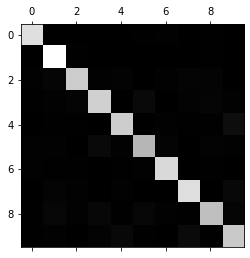

In [35]:
plt.matshow(voting_clf2_confusion_train, cmap=plt.cm.gray)
plt.show()